# Introduction

With the importance placed on getting a college degree nowadays ([65 percent of workers have at least some postsecondary education](https://cew.georgetown.edu/cew-reports/americas-divided-recovery/)), students more than ever need to focus on getting into colleges that will best help them achieve their goals. Sites like [US News](https://www.usnews.com/best-colleges) have become the de-facto standard for students trying to search through hundreds of universities and deciding which is the best fit. Specifically, US News' ranking system is given enormous weight, influencing [how schools are perceived by the general public](https://www.forbes.com/sites/robertzafft/2021/12/07/us-news-business-school-rankings-crucial-but-meaningless/). As such, it's very useful to take a look at these rankings, and the data set from which they are derived, in order to learn more about this driving force in college admissions and hopefully learn the patterns behind the data.



## Web Scraping
After spending 8 hours or so writing a web scraper to get all the components from the website, it turns out that each page provides JSON objects that contain all the data in a much easier to extract format. Oh well. 

In [38]:
from bs4 import BeautifulSoup

html_doc = open("2022 Best National Universities US News Rankings.htm", encoding="utf8")
soup = BeautifulSoup(html_doc, 'html.parser')

In [39]:
anchors = soup.select('a[class*="card-name"]')
links = list(map(lambda x: x.get('href'), anchors))
print(links[:10])
print(len(links))

['https://www.usnews.com/best-colleges/princeton-university-2627', 'https://www.usnews.com/best-colleges/columbia-university-2707', 'https://www.usnews.com/best-colleges/harvard-university-2155', 'https://www.usnews.com/best-colleges/massachusetts-institute-of-technology-2178', 'https://www.usnews.com/best-colleges/yale-university-1426', 'https://www.usnews.com/best-colleges/stanford-university-1305', 'https://www.usnews.com/best-colleges/university-of-chicago-1774', 'https://www.usnews.com/best-colleges/university-of-pennsylvania-3378', 'https://www.usnews.com/best-colleges/california-institute-of-technology-1131', 'https://www.usnews.com/best-colleges/duke-university-2920']
392


In [40]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import json

link = "https://www.usnews.com/best-colleges/princeton-university-2627"

def get_soup_obj(link, subpage):
    url = link + "/" + subpage
    agent = {"User-Agent":'Mozilla/5.0'}
    response = requests.get(url, headers = agent)
    return BeautifulSoup(response.text, 'html.parser')

soup = get_soup_obj(link, "student-life")

Then, we look at the structure of the HTML files and find the line in the script containing the JSON object, and extract it:

In [77]:
def get_json_from_soup(soup_obj):
    script_json_line = soup_obj.find_all("script")[-2].contents[0].split("\n")[4]
    json_obj_str = script_json_line[script_json_line.find("{"):-1].replace("undefined","null")
    json_obj = json.loads(json_obj_str)
        
    base_key = 'src/containers/pages/education/higher-education/colleges/profile'
    json_data = json_obj.get(f'{base_key}/overview.js',False) or \
                json_obj.get(f'{base_key}/generic.js',False) or \
                json_obj.get(f'{base_key}/rankings.js',None)
    
    return json_data['data']['context']['data']['page'] 

The 'fields' data indicates how the data is structured, the 'schoolData' field provides the values, and 'schoolDetails' provides basic info not in 'schoolData'.

We can use these methods to get all the data from every university and put it in a single JSON object, with the university name as the key.

In [ ]:
all_univ_json_data = {}
pages = ["", "overall-rankings", "applying", "academics", "student-life", "paying", "campus-info"]
for link in links:
    json_out = {'fields': {}, 'data': {}}
    for page in pages:
        json_data_fields = get_json_from_soup(get_soup_obj(link,page))
        #print(page + "::" + str(json_data_fields)[:20])
        json_out['data'].update(json_data_fields['schoolData'])
        json_out['fields'].update(json_data_fields['fields'])
    json_out['details'] = get_json_from_soup(get_soup_obj(link,""))['schoolDetails']
    name = json_out['details']['displayName']
    all_univ_json_data[name] = json_out
    print(name)

In [155]:
with open('all_univ.json', 'w') as outfile:
    json.dump(all_univ_json_data, outfile)

### Part 1.2: Data Compression

In [4]:
import json

# Read in the university data
with open('all_univ.json', 'r') as infile:
    all_univ_json_data = json.load(infile)

There are a lot of unnecessary structure in this data that we can remove, to decrease the size of the file (i.e. make it small enough I can upload it to GitHub without using LFS) and make our analysis life a lot easier.

In [5]:
nested_fields = set()

# Add the initial key set for the field and the full (human-readable) name of the field to a dictionary
def create_field_label_keys():
    # Assumes that all of the possible data attributes are contained within the first university on the list
    # Even if this isn't true, it covers a vast majority of use cases, so it's acceptable to me
    key = {}
    # Iterate through fields, putting the labels and fieldNames into a dictionary for future reference
    for field in all_univ_json_data['Princeton University']['fields'].values():
        if 'fieldName' in field:
            key[field['fieldName']] = field['label']
    return key    
    
def get_data_value(univ, field_name):
    return univ['data'][field_name]['rawValue'] if 'rawValue' in univ['data'][field_name] else None

# Given a key, get the value associated, also extracting any nested fields associated with that key. 
def get_field_value(univ, field):
    if 'subFields' in field:
        subfields = {}
        for subfield in field['subFields']:
            subfield_fields = subfield['fields'] if "fields" in subfield else [subfield['field']] 
            for subfield_field in subfield_fields:
                nested_fields.add(subfield_field)
                subfields[subfield_field] = get_data_value(univ, subfield_field)
        return subfields
    else:
        if field['fieldName'] not in nested_fields:
            return get_data_value(univ, field['fieldName'])

# Returns a tuple; the first value is the actual data, the second is the additional part of the key mapping
def get_details_info(univ):
    univ_details = univ['details'].copy()
    univ_details.pop("mainRank")
    univ_details.pop("crossWalk")
    keys = {}
    ranks = {}
    for rank_name, rank_data in univ_details['ranks'].items():
        if rank_data['isPublic'] and not rank_data['locked']:
            keys[rank_name] = rank_data['displayName']
            ranks[rank_name] = rank_data['displayRank']
    univ_details['ranks'] = ranks
    return (univ_details, keys)

univ_keys = create_field_label_keys() # map between field keys and readable labels

all_univ_data = []
for name, univ in list(all_univ_json_data.items()):
    univ_data = {}
    # Add info from 'details'
    details_data, details_keys = get_details_info(univ)
    univ_keys.update(details_keys)
    univ_data.update(details_data)   
    
    for field in univ['fields'].values():
        if field['isPublic']: 
            field_value = get_field_value(univ, field)
            if field_value is not None:
                univ_data[field['fieldName']] = field_value

    all_univ_data.append(univ_data)
    #print(name)

In [6]:
with open('all_univ_compressed.json', 'w') as outfile:
    json.dump(all_univ_data, outfile)
with open('all_univ_compressed_key.json', 'w') as outfile:
    json.dump(univ_keys, outfile)

## Analysis

Loading in the "cleaned-up" data structure:

In [7]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import json

In [65]:
with open('all_univ_compressed.json', 'r') as infile:
    all_univ_data = json.load(infile)
with open('all_univ_compressed_key.json', 'r') as infile:
    data_key = json.load(infile)
univ_df = pd.DataFrame(all_univ_data)

In [66]:
univ_df.head()

,primaryKey,xwalkId,urlName,displayName,shortName,city,state,zip,website,streetAddress1,...,regPctAllCars,schoolStatementText,schoolStatementUrl,schoolStatementUpdateDateTime,dlHousingDeposit,trfMinGpaCol,trfGuaranteedAdmUrl,vInStateTuition,vOutStateTuition,internationalTestReqMichiganTest
0,2627,186131,princeton-university,Princeton University,Princeton University,Princeton,NJ,08544,http://www.princeton.edu,N/A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2707,190150,columbia-university,Columbia University,Columbia University,New York,NY,10027,http://www.columbia.edu,2960 Broadway,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2155,166027,harvard-university,Harvard University,Harvard University,Cambridge,MA,02138,http://www.harvard.edu/,N/A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2178,166683,massachusetts-institute-of-technology,Massachusetts Institute of Technology,Massachusetts Institute of Technology,Cambridge,MA,02139,http://web.mit.edu/,77 Massachusetts Avenue,...,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1426,130794,yale-university,Yale University,Yale University,New Haven,CT,06520,http://www.yale.edu/,N/A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Tidy Data, Missing Data
Looking at this data, you may notice that there are many nested values, represented as strings of JSON in this data frame.

In [67]:
univ_df["gStudentGenderDistribution"]

0          {'vPctUnderMen': 50, 'vPctUnderWomen': 50}
1          {'vPctUnderMen': 49, 'vPctUnderWomen': 51}
2          {'vPctUnderMen': 49, 'vPctUnderWomen': 51}
3          {'vPctUnderMen': 52, 'vPctUnderWomen': 48}
4          {'vPctUnderMen': 50, 'vPctUnderWomen': 50}
                            ...                      
387    {'vPctUnderMen': None, 'vPctUnderWomen': None}
388        {'vPctUnderMen': 37, 'vPctUnderWomen': 63}
389        {'vPctUnderMen': 40, 'vPctUnderWomen': 60}
390        {'vPctUnderMen': 45, 'vPctUnderWomen': 55}
391        {'vPctUnderMen': 35, 'vPctUnderWomen': 65}
Name: gStudentGenderDistribution, Length: 392, dtype: object

One way we can deal with variables like these is by using `json_normalize` to split them up into separate columns:

In [68]:
univ_df = pd.json_normalize(univ_df.to_dict('records'), sep="_") # un-nest the nested variables 
univ_df[["gStudentGenderDistribution_vPctUnderMen", "gStudentGenderDistribution_vPctUnderWomen"]]

,gStudentGenderDistribution_vPctUnderMen,gStudentGenderDistribution_vPctUnderWomen
0,50.0,50.0
1,49.0,51.0
2,49.0,51.0
3,52.0,48.0
4,50.0,50.0
...,...,...
387,NaN,NaN
388,37.0,63.0
389,40.0,60.0
390,45.0,55.0


Another thing we need to deal with is the high number of missing data points, which results in the data being untidy -- in other words, there's a lot of columns which are close to empty.

[Text(0.5, 0, 'Number of Rows Missing Data')]

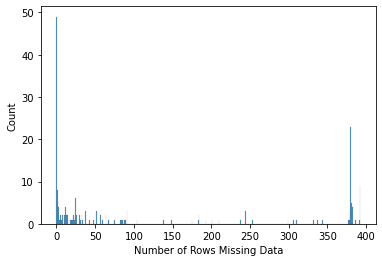

In [69]:
df_nas = univ_df.isna().sum()
ax = sns.histplot(df_nas, discrete=True)
ax.set(xlabel="Number of Rows Missing Data") 

Most of the variables have few to no missing data, but there's a long tail to the right of 0 followed by a massive spike slightly under 400 (indicating that there are some variables where almost none of the rows have that data). For the values where there are too many missing points, the best solution is to just drop them, because they won't be particularly useful in our analysis anyways (since they contribute so little information). Let's use a somewhat arbitrary threshold of one third (so at least 2/3 of the data must be non-null).

In [64]:
univ_df.dropna(axis=1, thresh=len(univ_df)*2//3, inplace=True)
univ_df

,primaryKey,xwalkId,urlName,displayName,shortName,city,state,zip,website,streetAddress1,...,gSororityMembers_stuCatSororityUg,gSororityMembers_stuCatNoSororityUg,csAvgCostIncome_nptLo,csAvgCostIncome_nptMed1,csAvgCostIncome_nptMed2,csAvgCostIncome_nptHi1,csAvgCostIncome_nptHi2,csTypicalDebtIncome_loIncDebtMdn,csTypicalDebtIncome_mdIncDebtMdn,csTypicalDebtIncome_hiIncDebtMdn
0,2627,186131,princeton-university,Princeton University,Princeton University,Princeton,NJ,08544,http://www.princeton.edu,N/A,...,0,100,1386.0,2044.0,7576.0,16989.0,36747.0,3865.0,6001.0,12000.0
1,2707,190150,columbia-university,Columbia University,Columbia University,New York,NY,10027,http://www.columbia.edu,2960 Broadway,...,12,88,8916.0,4287.0,5887.0,18637.0,42199.0,24130.0,16750.0,15000.0
2,2155,166027,harvard-university,Harvard University,Harvard University,Cambridge,MA,02138,http://www.harvard.edu/,N/A,...,0,0,2973.0,1010.0,3411.0,15553.0,46160.0,12500.0,15000.0,10250.0
3,2178,166683,massachusetts-institute-of-technology,Massachusetts Institute of Technology,Massachusetts Institute of Technology,Cambridge,MA,02139,http://web.mit.edu/,77 Massachusetts Avenue,...,26,74,4535.0,1820.0,6049.0,14381.0,38934.0,6993.0,6155.0,13000.0
4,1426,130794,yale-university,Yale University,Yale University,New Haven,CT,06520,http://www.yale.edu/,N/A,...,0,0,2125.0,1647.0,2167.0,11492.0,43417.0,10163.0,8205.0,15857.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,2525,179964,william-woods-university,William Woods University,William Woods University,Fulton,MO,65251,http://www.williamwoods.edu,1 University Avenue,...,0,0,21691.0,26790.0,23510.0,24531.0,26885.0,11083.0,13800.0,16423.0
388,7948,131113,wilmington-university,Wilmington University,Wilmington University,New Castle,DE,19720,http://www.wilmu.edu,320 Dupont Highway,...,0,0,14599.0,15092.0,15400.0,18123.0,NaN,15105.0,15500.0,13971.0
389,2985,199962,wingate-university,Wingate University,Wingate University,Wingate,NC,28174,https://www.wingate.edu/,220 N. Camden Rd.,...,12,88,15876.0,16798.0,17415.0,21569.0,24421.0,9500.0,12000.0,12580.0
390,9168,206604,wright-state,Wright State University,Wright State,Dayton,OH,45435,http://www.wright.edu,3640 Colonel Glenn Highway,...,0,0,13460.0,14755.0,16908.0,19223.0,19515.0,15000.0,14199.0,13500.0


This still leaves us with a large number of data values which have a relatively high number of missing values, however. The way these are handled depends on the situation at hand, so I cannot just deal with them all of them at once. In addition, the data set is too large to catch every formatting issue and mistake in collection, so those will be handled as they come up.

### What *Is* The US News Ranking?

US News gives all colleges a score on a scale from 0 to 100, where a higher number is better. This is based on a number of factors which they describe on [their website](https://www.washingtonpost.com/education/2018/09/12/us-news-changed-way-it-ranks-colleges-its-still-ridiculous/). Unfortunately, unless you pay for premium access, you are only able to see a small portion of the factors that go into the ranking.

This means that it's impossible for us to perfectly re-calculate the rankings from this data.  

First, let's take a look at a random sample of the rankings:

In [71]:
univ_df.sample(30)['vDisplayScore']

146            56
288            42
48             70
23             81
248            45
14             88
291            42
226            47
387    Bottom 25%
247            46
20             83
36             76
114            60
174            53
74             65
308    Bottom 25%
216            48
150            55
346    Bottom 25%
137            56
362    Bottom 25%
304    Bottom 25%
38             74
33             77
162            54
240            46
9              93
269            44
298    Bottom 25%
229            47
Name: vDisplayScore, dtype: object

We can see that some of the values, instead of being numeric, are instead the text value "Bottom 25%". This is because US News doesn't report a score for any university in the bottom 25 percent of the data. In order to do a numeric analysis, we have to discard those values. However, this is likely to have an impact on our analysis, so we need to keep it in mind. In data science terms, this data is technically **Missing Not At Random (MNAR)**, because while the rank is dependent on some of the factors that we have in the data set, there are other factors that we can't access that also have an effect (locked only for Premium users). The only statistically appropriate thing to do here is to remove the missing data, then restrict the domain of this analysis -- in other words, **all of the following calculations regarding the university scores only apply to universities in the top 75 percentile of US News rankings**. 

In [105]:
univ_df["vDisplayScoreInt"] = univ_df["vDisplayScore"].apply(lambda x: x if isinstance(x,int) else np.nan)

After that, let's look at the distribution of the remaining scores:

<AxesSubplot:xlabel='vDisplayScoreInt', ylabel='Count'>

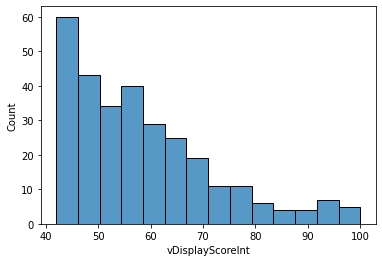

In [104]:
sns.histplot(x="vDisplayScoreInt",data=univ_df,bins=14)

The display scores appear to have a strong rightward skew -- in other words, there are many values in the 40s and 60s, there are only a few with a score of 90 or above. However, despite the ranking scale going from 0 to 100, the minimum value in this data set is only in the low 40s, on account of the missing 25 percent. It's possible (or even likely) that there is supposed to be a similar tail on the left side of this distribution that is not included in the data. 

## Exploring Known Factors For Ranks & Predicting

A non-paying reader of the US News website can only see data about the average graduation rate, student class sizes, and the student-faculty ratio. But how much do those factors matter? Is the correlation between the different factors strong enough that we can predict the rankings using only the factors that we can access for free? 

(**NOTE:** Ordinarily you would do complete EDA (Exploratory Data Analysis) before prediction, but since I already know there is a relationship here I'm going straight into prediction.)

In [74]:
ranking_factors = ["rCAvgPctGrad6Yr", "pellGradRate",  "nonPellGradrate", 
                   "rCPctClasses119", "rCPctClassesGt50", "vStudentFacultyRatio"]
univ_df_known_rank = univ_df[["vDisplayScoreInt"] + ranking_factors]

For one, we need to address the issue with the student-faculty ratio -- namely, that it's a string, not numeric. 

In [75]:
univ_df["vStudentFacultyRatio"] = univ_df["vStudentFacultyRatio"].apply(\
                        lambda x: int(x[:-2]) if pd.notna(x) else np.nan)

Let's also look at the number of missing values in the factors:

In [76]:
temp_rank = univ_df_known_rank.copy().dropna(subset=["vDisplayScoreInt"])
temp_rank.isna().sum()

vDisplayScoreInt        0
rCAvgPctGrad6Yr         0
pellGradRate            8
nonPellGradrate         8
rCPctClasses119         2
rCPctClassesGt50        2
vStudentFacultyRatio    6
dtype: int64

There are few to no missing data values within the set of universities in teh 75th percentile, so dealing with these values is of minor concern. 

US News says that the ranking is calculated by using the "sum" of various factors weighted by some percentages. This implies that we should use a linear regression model -- simply take the values in the data set, scale them based on the percentage weights described on the website, and use that as a predictor. However, in order for this model to make sense, we have to make the assumption that the variables vary linearly with respect to desired output variable (the score). Let's check that graphically:

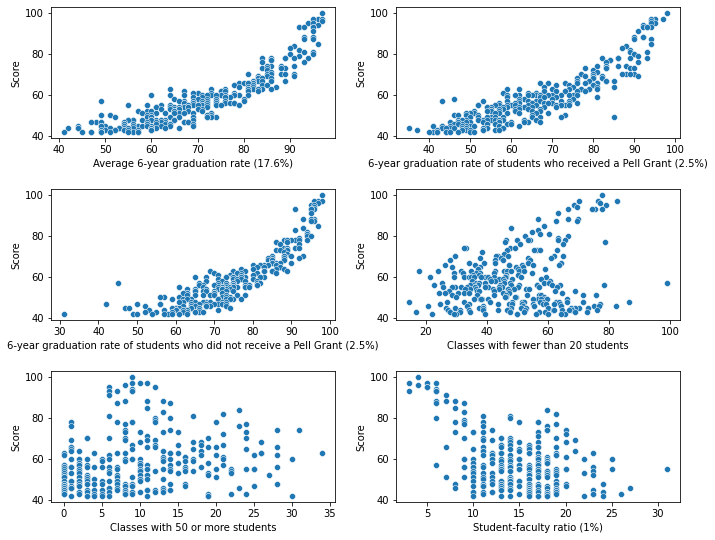

In [77]:
from math import ceil 

def plot_factors_against_score(ranking_factors, ncols, df=univ_df):
    fig, axes = plt.subplots(nrows=ceil(len(ranking_factors)/ncols), ncols=ncols, figsize=(10,8))
    fig.tight_layout(pad=3.0)
    for col, ax in zip(ranking_factors, fig.axes):
        sns.scatterplot(ax=ax, x=col, y="vDisplayScoreInt", data=df)
        ax.set(xlabel=data_key.get(col, col), ylabel="Score")
        
plot_factors_against_score(ranking_factors, 2)

This data is very interesting -- some of these appear to have little to no correlation with the data (specifically those relating to class sizes) and some of these have a quite strong, *non-linear* relationship (specifically those regarding graduation rates). Therefore, a linear model is definitely not a good idea here.

#### Transforming The Data
Let's focus in on just one of these factors -- 6-year graduation rate. The direct relationship is expected because of the formula US News described, but it's unusual that the relationship isn't linear. Since these metrics are artificially created by US News, one would expect there to be a more obvious mathematical relationship between the ranking factors and the rank. According to the [US News website](https://www.usnews.com/education/best-colleges/articles/how-us-news-calculated-the-rankings), they "normalize" the values before they are put into the calculation. This may mean that instead of looking at the raw value, we should look at the *z-score* of each ranking, which is a measure that describes how far away from the mean the value is. In fact, US News says that they "z-scored" the *predicted* graduation rate [in the supplementary material on their website](https://www.usnews.com/media/best-colleges/graduation-rate-performance). However, for z-score to be a useful measure, we would also need to make the assumption that scores are normally distributed. Let's check that first, by observation: 

[Text(0.5, 0, 'Average 6-year graduation rate (17.6%)')]

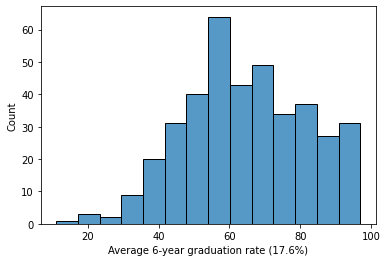

In [83]:
ax = sns.histplot(x="rCAvgPctGrad6Yr",data=univ_df,bins=14)
ax.set(xlabel=data_key["rCAvgPctGrad6Yr"])

(Note: this is including the schools with the bottom 25 percent score, which is desired in this case.) 

This data has a meaningful leftward skew. To quantify this more accurately, we can use a QQ plot, which compares the *quantiles* (percentiles) of the sample with what would be expected if the sample was normally distributed. If the sample is perfectly normal, then we would expect to see a perfect line. 

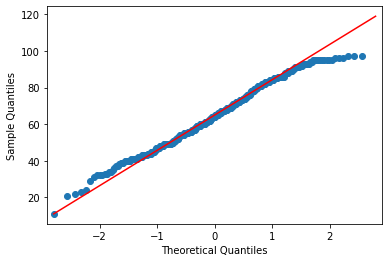

In [84]:
ax = sm.qqplot(univ_df["rCAvgPctGrad6Yr"], line="q")

The deviation from the line at the lower and higher quantiles shows that this isn't exactly normal, so it's unlikely that US News would use this for normalization. We can double-check by looking at the scatterplot with the z-scores:

[Text(0.5, 32.99999999999995, 'Average 6-Year Graduation Percentage (z-score)'),
 Text(27.125, 0.5, 'Score')]

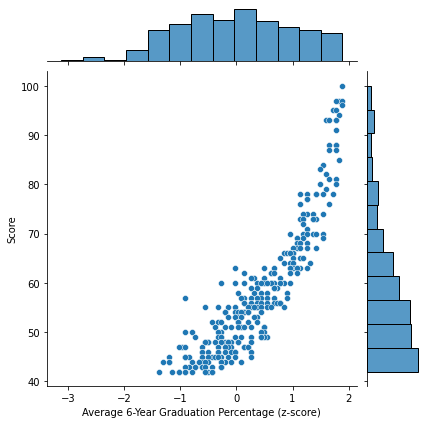

In [85]:
univ_df["rCAvgPctGrad6YrZScore"] = (univ_df["rCAvgPctGrad6Yr"] -univ_df["rCAvgPctGrad6Yr"].mean())/univ_df["rCAvgPctGrad6Yr"].std(ddof=0)
jp = sns.jointplot(x="rCAvgPctGrad6YrZScore",y="vDisplayScoreInt", data=univ_df)
jp.figure.axes[0].set(xlabel="Average 6-Year Graduation Percentage (z-score)", ylabel="Score")

That didn't change anything about the relationship. Another possible method of normalization is using percentiles -- does that "fix" the nonlinearity?

[Text(0.5, 32.99999999999995, 'Average 6-Year Graduation Percentage (percentile)'),
 Text(27.125, 0.5, 'Score')]

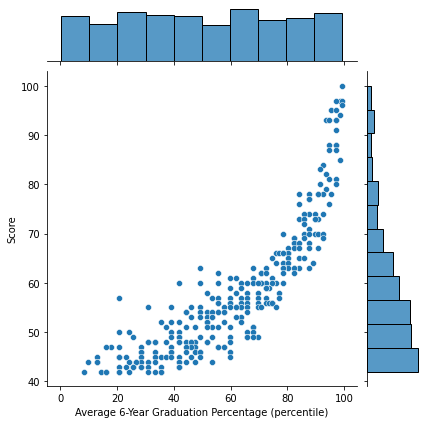

In [87]:
from scipy import stats
univ_df["rCAvgPctGrad6YrPercentile"] = univ_df["rCAvgPctGrad6Yr"].apply(lambda x: stats.percentileofscore(univ_df["rCAvgPctGrad6Yr"], x))
jp = sns.jointplot(x="rCAvgPctGrad6YrPercentile",y="vDisplayScoreInt", data=univ_df)
jp.figure.axes[0].set(xlabel="Average 6-Year Graduation Percentage (percentile)", ylabel="Score")

And we still see a non-linear relationship. This could indicate that US News uses a different normalization than expected, and doesn't explain how it works, or there is some other variable with a non-linear relationship to graduation rate that is also part of the rankings. More research is needed, possibly including discussion with US News, to determine what normalization is precisely used for these factors.

#### Predicting
The apparent strength of the graduation rate versus score relationship on the graph makes me wonder about how well a polynomial predictive model could do when input only the 6-year graduation rate (i.e. a single-variable model). After some experimentation, I found that a degree 3 polynomial yields sufficient accuracy while also not overfitting the data.

In [78]:
#https://ostwalprasad.github.io/machine-learning/Polynomial-Regression-using-statsmodel.html
from sklearn.preprocessing import PolynomialFeatures

# Extract the relevant data from the data frame, getting rid of NAs
univ_df_no_na = univ_df[pd.notna(univ_df["vDisplayScoreInt"])]
x = univ_df_no_na["rCAvgPctGrad6Yr"].ravel().reshape(-1, 1)
y = univ_df_no_na["vDisplayScoreInt"]

# Calculate the polynomial feature from the input data
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(x)

[Text(0.5, 32.99999999999995, 'Average 6-year graduation rate (17.6%)'),
 Text(27.125, 0.5, 'Score (out of 100)')]

<Figure size 720x720 with 0 Axes>

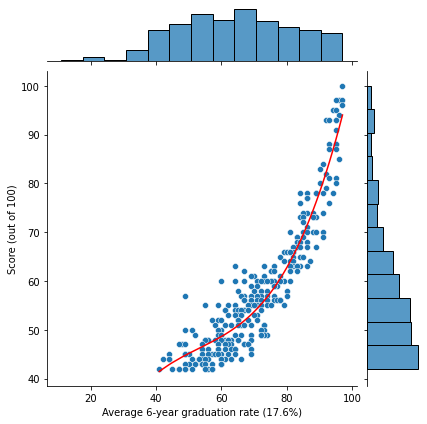

In [79]:
# Generate the model
import statsmodels.api as sm
model = sm.OLS(y,xp).fit()
ypred = model.predict(xp) 

# Display the scatterplot between the graduation rate and score rant, and show histograms of each variable 
plt.figure(figsize=(10, 10))
jp = sns.jointplot(x="rCAvgPctGrad6Yr",y="vDisplayScoreInt",data=univ_df)

# Plot the regression data
x, ypred = zip(*sorted(zip(x, ypred)))
ax = jp.figure.axes[0]
ax.plot(x,ypred, 'r')  
ax.set(xlabel=data_key["rCAvgPctGrad6Yr"], ylabel=data_key["vDisplayScore"])

In [80]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       vDisplayScoreInt   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     879.5
Date:                Mon, 20 Dec 2021   Prob (F-statistic):          1.90e-146
Time:                        16:30:14   Log-Likelihood:                -855.14
No. Observations:                 298   AIC:                             1718.
Df Residuals:                     294   BIC:                             1733.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.6150     28.749     -1.065      0.288     -87.196      25.966
x1             3.6685      1.273      2.883      0.004       1.164       6.173
x2            -0.0627      0.018     -3.415      0.001      -0.099      -0.027
x3             0.0004   8.66e-05      4.546      0.000       0.000       0.001
==============================================================================
Omnibus:                        1.801   Durbin-Watson:                   1.674
Prob(Omnibus):                  0.406   Jarque-Bera (JB):                1.739
Skew:                           0.187   Prob(JB):                        0.419
Kurtosis:                       2.977   Cond. No.                     5.25e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.25e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

With an R-squared of 0.9, we can see this is a really good predictor of ranking, even though it apparently only accounts for 17.6 percent of the ranking calculation. Furthermore, the p-values of the various factors are significantly below the standard threshold of 0.05, so they are clearly statistically significant.

## Other Predictors
Are there any other factors that correlate well with rank, despite not being used in the ranking calculation?

### Non-Quantitative Data
If we want to use the data to predict rankings, the easiest values to use are those with quantitative values as opposed to text values (it's possible to use categorical data for this regression, but that would take a lot of individual analysis for each of the variables, which should not be necessary to get a meaningful regression and result). 

In [108]:
univ_df_num = univ_df.select_dtypes([np.number]).copy() # remove columns which are non-numeric
univ_df_num.columns

Index(['latitude', 'longitude', 'rCAcceptRate', 'vStudentFacultyRatio',
       'gradRate4Year', 'totalAllStudents', 'vPrivateTuition', 'wRoomBoard',
       'rCAvgPctGrad6Yr', 'pellGradRate', 'nonPellGradrate', 'rCPctClasses119',
       'rCPctClassesGt50', 'applicationFee', 'totalUndergrads',
       'totalGradsAndPros', 'pctPell', 'enrollmentMilitaryTotalCyPct',
       'csAvgCost', 'csTypicalDebt', 'csTypicalDebtNograduate',
       'csTypicalLoanPayMonthly', 'avgGradDebt', 'pctIncuredDebt', 'vGiBill',
       'csPctRcvFedLoan', 'envCamSize', 'earlyDecAcceptRate', 'regPctAllCars',
       'trfMinGpaCol', 'vInStateTuition', 'vOutStateTuition',
       'gClassSizes_vClasses1', 'gClassSizes_vClasses2',
       'gClassSizes_vClasses3', 'gStudentGenderDistribution_vPctUnderMen',
       'gStudentGenderDistribution_vPctUnderWomen',
       'g_financial_aid_statistics_pctApplyFinAid',
       'g_financial_aid_statistics_pctNeedFullyMet',
       'g_financial_aid_statistics_pctRecvAidFt',
       'g_fina

### Missing Data 
As previously described, there are many data values which have very few data points, meaning that most of the universities have a missing (NaN) value. Let's look at the percentages for each data variable.

In [109]:
# Get the *percent* of rows with missing data
df_nas[df_nas > 0].apply(lambda x: x/len(univ_df_num)).sort_values().to_frame(name="Percent Missing")

,Percent Missing
csTypicalDebtIncome_hiIncDebtMdn,0.002551
csTypicalDebtIncome_loIncDebtMdn,0.002551
wRoomBoard,0.002551
totalGradsAndPros,0.002551
gSat1600ScaleChart_satGridRng799,0.002551
csTypicalDebtIncome_mdIncDebtMdn,0.002551
csAvgCostIncome_nptHi2,0.005102
csAvgCostIncome_nptHi1,0.005102
rCPctClasses119,0.005102
rCPctClassesGt50,0.005102


Most of the largest values are specific to certain categories of colleges; for example, a school won't have an `earlyDecAcceptRate` value if they don't allow early decision admissions. Data like this is **Missing At Random (MAR)**, meaning that we can predict whether it's missing based on other known factors. We will deal with these issues later.



Since we're exploring, let's look at the correlation between all of the values, all put into a single heat map.

(Keep in mind that these regressions are all using a linear model. It's entirely possible that there are weird, very non-linear relationships in this data that are strong but still result in a low correlation coefficient.)

<AxesSubplot:>

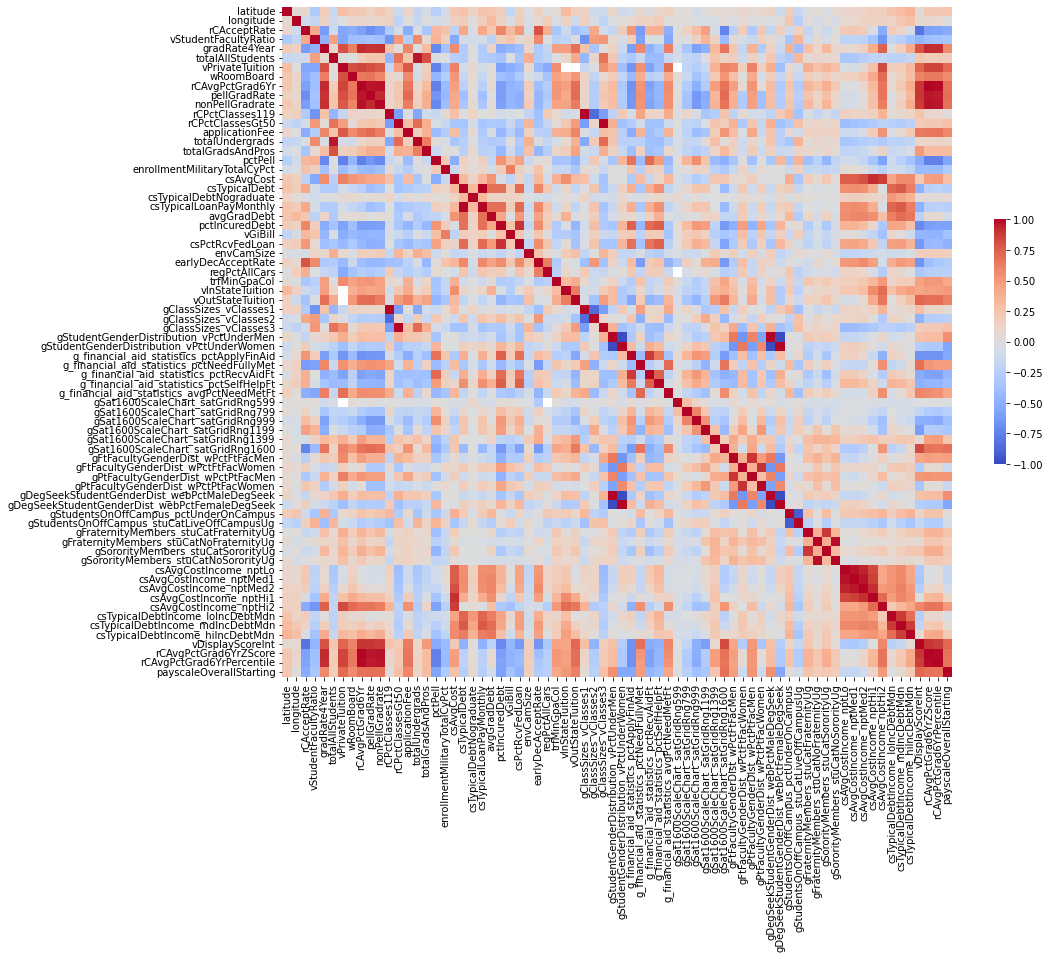

In [110]:
corr = univ_df_num.corr()
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, center=0, cmap='coolwarm',
            square=True, cbar_kws={"shrink": .3}, xticklabels=True, yticklabels=True)

(A very red cell means a strong positive correlation, while a very blue cell means a strong negative correlation.)

Just looking at this (admittedly intimidating) graph tells us a lot about correlations. Many of these correlations are obvious -- for example, the four-year graduation rate directly correlates with the 6-year graduation rate, and measures by gender (e.g. female enrollment and sorority enrollment) also correlate well. One other correlations that stands out to me is the inverse relation between `pctPell` and `rCAvgPctGrad6Yr`:

[Text(0.5, 0, 'Awarded Pell Grants (2019-2020)'),
 Text(0, 0.5, 'Average 6-year graduation rate (17.6%)')]

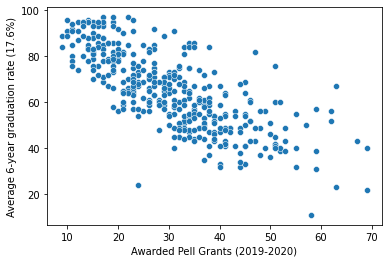

In [102]:
ax = sns.scatterplot(x="pctPell", y="rCAvgPctGrad6Yr", data=univ_df_num)
ax.set(xlabel=data_key["pctPell"], ylabel=data_key["rCAvgPctGrad6Yr"])

I would expect that schools with more Pell Grants would have a higher graduation rate, but the reverse is seen in the data. More research is needed to find the explanation for this.

Let's focus in on the specific variables which correlate with the score:

In [111]:
score_corrs = corr['vDisplayScoreInt'].sort_values()
score_corrs.head(10)

rCAcceptRate                                -0.812771
pctIncuredDebt                              -0.707936
g_financial_aid_statistics_pctApplyFinAid   -0.670634
earlyDecAcceptRate                          -0.655236
csPctRcvFedLoan                             -0.626404
gSat1600ScaleChart_satGridRng1199           -0.598200
pctPell                                     -0.524937
g_financial_aid_statistics_pctRecvAidFt     -0.520663
gSat1600ScaleChart_satGridRng999            -0.496213
csTypicalLoanPayMonthly                     -0.479792
Name: vDisplayScoreInt, dtype: float64

In [112]:
score_corrs.tail(10)

vOutStateTuition                     0.721870
vPrivateTuition                      0.731851
gradRate4Year                        0.793724
gSat1600ScaleChart_satGridRng1600    0.821466
rCAvgPctGrad6YrPercentile            0.862225
nonPellGradrate                      0.874309
pellGradRate                         0.890945
rCAvgPctGrad6Yr                      0.895538
rCAvgPctGrad6YrZScore                0.895538
vDisplayScoreInt                     1.000000
Name: vDisplayScoreInt, dtype: float64

Besides the already mentioned graduation rates (and ignoring the fact that score perfectly correlates with itself), we see two other factors that have a r-squared magnitude over 0.8: `gSat1600ScaleChart_satGridRng1600` (i.e. the percent of students that got a score of 1400-1600 on the SAT) and `rCAcceptRate` (the percent acceptance rate). 

[Text(0.5, 32.99999999999995, 'Acceptance Rate'), Text(27.125, 0.5, 'Score')]

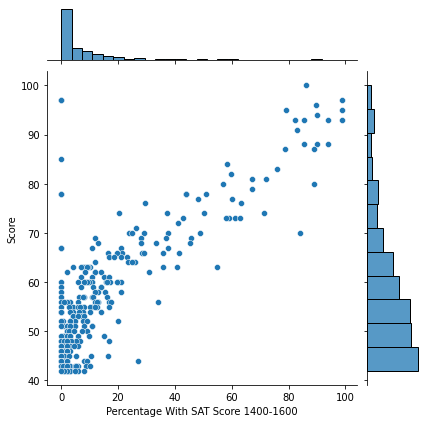

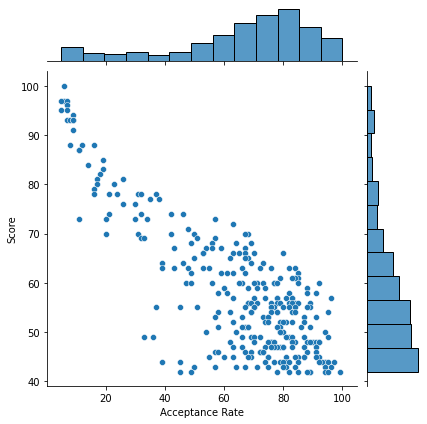

In [119]:
jp1 = sns.jointplot(x="gSat1600ScaleChart_satGridRng1600",y="vDisplayScoreInt", data=univ_df_num)
jp1.figure.axes[0].set(xlabel="Percentage With SAT Score 1400-1600", ylabel="Score")
jp2 = sns.jointplot(x="rCAcceptRate",y="vDisplayScoreInt", data=univ_df_num)
jp2.figure.axes[0].set(xlabel="Acceptance Rate", ylabel="Score")

After graphing, we can see some stray 0s in the SAT score graph, indicating an issue with the data. Investigating the relevant columns:

In [226]:
pd.set_option('display.max_columns', 20)
univ_df[univ_df["gSat1600ScaleChart_satGridRng1600"]==0].filter(regex="displayName|gSat1600ScaleChart")

,displayName,gSat1600ScaleChart_satGridRng599,gSat1600ScaleChart_satGridRng799,gSat1600ScaleChart_satGridRng999,gSat1600ScaleChart_satGridRng1199,gSat1600ScaleChart_satGridRng1399,gSat1600ScaleChart_satGridRng1600
1,Columbia University,0.0,0.0,0.0,0.0,0.0,0.0
2,Harvard University,0.0,0.0,0.0,0.0,0.0,0.0
18,University of Notre Dame,0.0,0.0,0.0,0.0,0.0,0.0
27,New York University,0.0,0.0,0.0,0.0,0.0,0.0
28,Tufts University,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
383,Washburn University,0.0,0.0,0.0,0.0,0.0,0.0
387,William Woods University,0.0,0.0,0.0,0.0,0.0,0.0
388,Wilmington University,0.0,0.0,0.0,0.0,0.0,0.0
389,Wingate University,0.0,3.0,44.0,42.0,11.0,0.0


For many of these universities, their SAT distribution simply wasn't recorded. We can filter these out relatively easily:

[Text(0.5, 32.99999999999995, 'Percentage With SAT Score 1400-1600'),
 Text(27.125, 0.5, 'Score')]

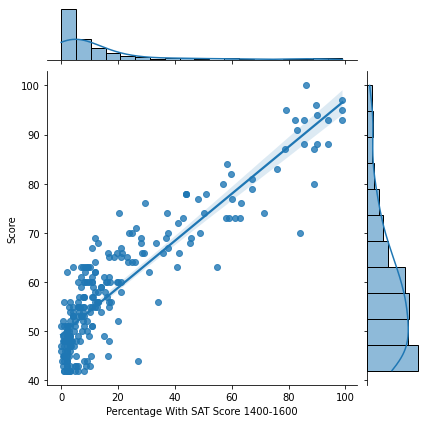

In [241]:
univ_df_num_sat = univ_df_num[univ_df_num.filter(regex="gSat1600ScaleChart").sum(axis=1) > 99]
jp1 = sns.jointplot(x="gSat1600ScaleChart_satGridRng1600",y="vDisplayScoreInt", kind="reg", data=univ_df_num_sat)
jp1.figure.axes[0].set(xlabel="Percentage With SAT Score 1400-1600", ylabel="Score")

In [238]:
univ_df_num_sat.corr()["gSat1600ScaleChart_satGridRng1600"]["vDisplayScoreInt"]

0.8986465773373142

With that change, the correlation between university ranking score and the proportion highest SAT scorers jumps all the way to 0.90, making it the variable with the greatest linear correlation.

## Rank And Salary/Debt

One metric I'm particularly interested in is: Does the ranking done by US News correlate with other metrics of success, like starting salary? Unfortunately, because this scraper doesn't by itself get the data about average salary, I need to supplement this with another web scraper I wrote which directly reads from the webpage ([**link**](https://github.com/Aurathic/USNews-Colleges-Web-Scraper/blob/master/python_web_scraper/web_scraping.ipynb)), whose code will not be included here for the sake of brevity.

In [ ]:
salaries = pd.read_csv("all_univ_rows.csv")["Median starting salary of alumni "].apply( 
          lambda x: x if pd.isna(x) else int(x[1:].replace(",","")))
univ_df['payscaleOverallStarting'] = salaries

[Text(0.5, 1.0, 'Median Alumni Starting Salary vs University Scores'),
 Text(0.5, 0, 'Median Salary of Recent Alumni (USD)'),
 Text(0, 0.5, 'US News Score (0-100)')]

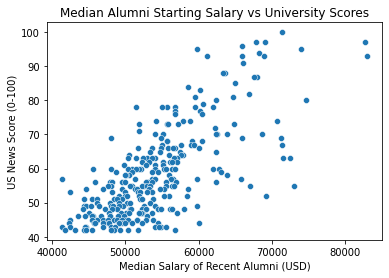

In [ ]:
ax = sns.scatterplot(data=univ_df, x="payscaleOverallStarting", y="vDisplayScoreInt")
ax.set(title="Median Alumni Starting Salary vs University Scores",xlabel="Median Salary of Recent Alumni (USD)",ylabel="US News Score (0-100)")

In [ ]:
ax = sns.scatterplot(data=univ_df, x="payscaleOverallStarting", y="rCAvgPctGrad6Yr")

We can see a decent positive linear correlation, as we'd expect. We can quantify the relationship with a predictive model:

In [136]:
reg = smf.ols("vDisplayScoreInt ~ payscaleOverallStarting", data=univ_df).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       vDisplayScoreInt   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     317.8
Date:                Mon, 20 Dec 2021   Prob (F-statistic):           8.50e-49
Time:                        17:30:04   Log-Likelihood:                -1089.2
No. Observations:                 298   AIC:                             2182.
Df Residuals:                     296   BIC:                             2190.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -15.4176      4.175     -3.693      0.000     -23.633      -7.202
payscaleOverallStarting     0.0014   7.64e-05     17.827      0.000       0.001       0.002
==============================================================================
Omnibus:                        2.100   Durbin-Watson:                   1.016
Prob(Omnibus):                  0.350   Jarque-Bera (JB):                1.805
Skew:                           0.142   Prob(JB):                        0.406
Kurtosis:                       3.255   Cond. No.                     4.19e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.19e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

An r-squared of 0.518 means that there is some correlation, but it's not particularly strong.

#### Considering Major

However, the school one attends is obviously not the only factor that controls your salary. One huge factor is your field -- chemical engineers, on average, earn significantly more than English teachers. Fortunately, this data set also has data regarding the ten most popular majors in each university. Let's, for example, look at the most popular majors at the universities with the 10 highest and lowest average starting salaries:

In [120]:
univ_df_sal_maj = univ_df[["topMajors","payscaleOverallStarting","displayName"]].copy()
univ_df_sal_maj = univ_df_sal_maj[univ_df_sal_maj["topMajors"].map(lambda d: len(d) > 0)]
univ_df_sal_maj.sort_values("payscaleOverallStarting", inplace=True, ignore_index=True)

pd.set_option('display.max_colwidth', None)
univ_df_sal_maj.head(10)

,topMajors,payscaleOverallStarting,displayName
0,"[[Business Administration, Management and Operations, 17], [Liberal Arts and Sciences, General Studies and Humanities, 15], [Social Work, 9], [Health and Medical Administrative Services, 8], [Registered Nursing, Nursing Administration, Nursing Research and Clinical Nursing, 8], [English Language and Literature, General, 5], [Criminology, 4], [Dentistry, 4], [Marketing, 4], [Psychology, General, 3]]",37400.0,Mary Baldwin University
1,"[[Registered Nursing/Registered Nurse, 39], [Natural Sciences, 25], [Health and Wellness, General, 4], [Social Work, 4], [Psychology, General, 4], [Special Education and Teaching, General, 3], [Digital Arts, 2], [Biology/Biological Sciences, General, 2], [Marketing/Marketing Management, General, 2], [Accounting, 2]]",40800.0,Daemen College
2,"[[Nurse Anesthetist, 21], [Business Administration and Management, General, 13], [Multi-/Interdisciplinary Studies, Other, 6], [Psychology, General, 5], [Bilingual and Multilingual Education, 4], [Accounting, 4], [Educational Leadership and Administration, General, 4], [Management Science, 4], [Criminal Justice/Safety Studies, 3], [Counseling Psychology, 3]]",41300.0,Texas Wesleyan University
3,"[[Business, Management, Marketing, and Related Support Services, 19], [Biological and Biomedical Sciences, 16], [Parks, Recreation, Leisure, Fitness, and Kinesiology, 15], [Psychology, 9], [Communication, Journalism, and Related Programs, 7], [Public Administration and Social Service Professions, 7], [Education, 6], [Health Professions and Related Programs, 6], [Homeland Security, Law Enforcement, Firefighting and Related Protective Services, 4], [Physical Sciences, 2]]",41800.0,Wingate University
4,"[[Health Professions and Related Programs, 28], [Business, Management, Marketing, and Related Support Services, 26], [Homeland Security, Law Enforcement, Firefighting and Related Protective Services, 10]]",41800.0,Husson University
5,"[[Business, Management, Marketing, and Related Support Services, 26], [Health Professions and Related Programs, 13], [Communication, Journalism, and Related Programs, 8], [Education, 7], [Psychology, 7], [Liberal Arts and Sciences, General Studies and Humanities, 6], [Social Sciences, 5], [Biological and Biomedical Sciences, 5], [Visual and Performing Arts, 4], [Homeland Security, Law Enforcement, Firefighting and Related Protective Services, 4]]",42100.0,Valdosta State University
6,"[[Business Administration and Management, General, 14], [Registered Nursing/Registered Nurse, 12], [Biology/Biological Sciences, General, 7], [Psychology, General, 5], [Accounting, 4], [Exercise Science and Kinesiology, 4], [Special Education and Teaching, General, 4], [Speech Communication and Rhetoric, 4], [Human Services, General, 3], [Elementary Education and Teaching, 3]]",42200.0,Carson-Newman University
7,"[[Business, Management, Marketing, and Related Support Services, 12], [Biological and Biomedical Sciences, 11], [Communication, Journalism, and Related Programs, 10], [Parks, Recreation, Leisure, Fitness, and Kinesiology, 10], [Social Sciences, 10], [Physical Sciences, 7], [Psychology, 7], [Health Professions and Related Programs, 6], [Education, 5], [Public Administration and Social Service Professions, 5]]",42300.0,Delaware State University
8,"[[Biological and Biomedical Sciences, 16], [Health Professions and Related Programs, 13], [Psychology, 12], [Business, Management, Marketing, and Related Support Services, 10], [Multi/Interdisciplinary Studies, 9], [Communication, Journalism, and Related Programs, 8], [Architecture and Related Services, 7], [Parks, Recreation, Leisure, Fitness, and Kinesiology, 5], [Education, 4], [English Language and Literature/Letters, 4]]",42400.0,Chatham University
9,"[[Speech Communication and Rhetoric, 13], [Psychology, General, 12], [Business Administration and Management, General, 9], [Bible/Biblical Studies, 8], [English Language and Literature, General, 6], [Cybersecur

In [121]:
univ_df_sal_maj.tail(10)

,topMajors,payscaleOverallStarting,displayName
334,"[[Engineering, 53], [Computer and Information Sciences and Support Services, 18], [Business, Management, Marketing, and Related Support Services, 5], [Engineering/Engineering-Related Technologies/Technicians, 5], [Mathematics and Statistics, 4], [Physical Sciences, 4], [Biological and Biomedical Sciences, 3], [Architecture and Related Services, 3], [Visual and Performing Arts, 3], [Multi/Interdisciplinary Studies, 2]]",71200.0,Rensselaer Polytechnic Institute
335,"[[Social Sciences, 20], [Engineering, 15], [Computer and Information Sciences and Support Services, 12], [Biological and Biomedical Sciences, 10], [Public Administration and Social Service Professions, 9], [Physical Sciences, 7], [History, 6], [Foreign Languages, Literatures, and Linguistics, 4], [English Language and Literature/Letters, 3], [Philosophy and Religious Studies, 3]]",71300.0,Princeton University
336,"[[Mechanical Engineering, 23], [Computer Science, 16], [Bioengineering and Biomedical Engineering, 9], [Electrical and Electronics Engineering, 8], [Mechatronics, Robotics, and Automation Engineering, 8], [Chemical Engineering, 7], [Civil Engineering, General, 5], [Aerospace, Aeronautical, and Astronautical/Space Engineering, General, 4], [Biology/Biological Sciences, General, 4], [Industrial Engineering, 3]]",71400.0,Worcester Polytechnic Institute
337,"[[Mechanical Engineering, 20], [Business Administration and Management, General, 12], [Computer Science, 10], [Computer Engineering, General, 8], [Chemical Engineering, 8], [Financial Mathematics, 7], [Bioengineering and Biomedical Engineering, 6], [Civil Engineering, General, 6], [Electrical and Electronics Engineering, 5], [Engineering/Industrial Management, 3]]",71500.0,Stevens Institute of Technology
338,"[[Mechanical Engineering, 30], [Computer Science, 12], [Chemical Engineering, 10], [Petroleum Engineering, 8], [Electrical and Electronics Engineering, 7], [Civil Engineering, General, 6], [Geological/Geophysical Engineering, 5], [Engineering Physics/Applied Physics, 5], [Environmental/Environmental Health Engineering, 4], [Metallurgical Engineering, 4]]",72400.0,Colorado School of Mines
339,"[[Computer and Information Sciences and Support Services, 17], [Multi/Interdisciplinary Studies, 17], [Engineering, 16]]",73900.0,Stanford University
340,"[[Computer Science, 13], [Business Administration and Management, General, 9], [Electrical and Electronics Engineering, 9], [Systems Science and Theory, 9], [Mechanical Engineering, 8], [Statistics, General, 7], [Biology/Biological Sciences, General, 3], [Drama and Dramatics/Theatre Arts, General, 3], [Chemical Engineering, 3], [Architectural and Building Sciences/Technology, 2]]",74600.0,Carnegie Mellon University
341,"[[Computer Science, 33], [Mechanical Engineering, 11], [Mathematics, General, 9], [Physics, General, 6], [Aerospace, Aeronautical, and Astronautical/Space Engineering, General, 4], [Bioengineering and Biomedical Engineering, 4], [Econometrics and Quantitative Economics, 4], [Electrical and Electronics Engineering, 3], [Biology/Biological Sciences, General, 3], [Chemical Engineering, 2]]",82700.0,Massachusetts Institute of Technology
342,"[[Computer and Information Sciences and Support Services, 35], [Engineering, 26], [Physical Sciences, 24], [Mathematics and Statistics, 8], [Biological and Biomedical Sciences, 7], [Multi/Interdisciplinary Studies, 1]]",82900.0,California Institute of Technology
343,"[[Business Administration and Management, General, None]]",NaN,Alliant International University


We can see generally, the highest-salary schools have high representation of computer science and engineering field, while there are a surprising number of Business degrees at the lowest-salaried universities. To quantify this more concretely, let's split up the groups into several groups based on their score, then count the majors in the top 10 for each and see if any patterns emerge.

In [245]:
from collections import Counter

df_majors_pay = univ_df[["payscaleOverallStarting", "topMajors"]].copy()
df_majors_pay["topMajorsList"] = df_majors_pay["topMajors"].apply(lambda x: [i[0] for i in x])
df_majors_pay = df_majors_pay.explode("topMajorsList")
pay_group = df_majors_pay[["payscaleOverallStarting","topMajorsList"]].groupby(pd.qcut(df_majors_pay["payscaleOverallStarting"],10)) # group majors 
pay_counters = pay_group["topMajorsList"].apply(list).apply(lambda x: dict(Counter(x).most_common(10))) # count the representation, only look at the 10 most common in the top 10s in this group
df_majors_count_pay_temp = pd.DataFrame(pay_counters).apply(lambda x: pd.Series(x))
df_majors_count_pay = pd.json_normalize(df_majors_count_pay_temp["topMajorsList"]) # put into a nice DataFrame form
df_majors_count_pay.index = df_majors_count_pay_temp.index # transfer over the index
df_majors_count_pay

,"Business, Management, Marketing, and Related Support Services",Health Professions and Related Programs,Biological and Biomedical Sciences,Psychology,"Psychology, General","Communication, Journalism, and Related Programs",Education,NaN,"Business Administration and Management, General","Biology/Biological Sciences, General",Social Sciences,Visual and Performing Arts,"Parks, Recreation, Leisure, Fitness, and Kinesiology",Engineering,"Homeland Security, Law Enforcement, Firefighting and Related Protective Services",Computer and Information Sciences and Support Services,Mechanical Engineering,Physical Sciences,Mathematics and Statistics,Computer Science
payscaleOverallStarting,,,,,,,,,,,,,,,,,,,,
"(37399.999, 44600.0]",18,16.0,16,16.0,16.0,15.0,15.0,14.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(44600.0, 47700.0]",22,21.0,15,21.0,15.0,11.0,14.0,NaN,NaN,NaN,15.0,15.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(47700.0, 48800.0]",20,18.0,19,20.0,NaN,14.0,13.0,NaN,NaN,NaN,17.0,11.0,NaN,15.0,10.0,NaN,NaN,NaN,NaN,NaN
"(48800.0, 50200.0]",24,22.0,22,21.0,NaN,13.0,17.0,NaN,NaN,NaN,17.0,16.0,NaN,15.0,NaN,14.0,NaN,NaN,NaN,NaN
"(50200.0, 51900.0]",19,17.0,18,16.0,13.0,11.0,10.0,NaN,NaN,NaN,16.0,NaN,10.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN
"(51900.0, 53360.0]",21,17.0,20,16.0,14.0,15.0,15.0,NaN,NaN,10.0,18.0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN
"(53360.0, 55300.0]",22,15.0,20,21.0,10.0,16.0,NaN,NaN,NaN,NaN,21.0,11.0,NaN,14.0,NaN,14.0,NaN,NaN,NaN,NaN
"(55300.0, 57100.0]",25,20.0,27,23.0,NaN,16.0,NaN,NaN,NaN,NaN,24.0,16.0,12.0,23.0,NaN,21.0,NaN,NaN,NaN,NaN
"(57100.0, 62800.0]",18,16.0,21,18.0,NaN,11.0,NaN,NaN,NaN,10.0,19.0,13.0,NaN,21.0,NaN,18.0,NaN,NaN,NaN,NaN


The values represent the number of colleges in each bin which have the given major in their top 10. So, for example, in the lowest average starting pay range, 18 of the universities had "Business, Management, Marketing, and Related Support Services" in their top 10.

When displayed like this, we see that overall, the differences in major across the groups are not as significant as expected. "Business, Management, Marketing, and Related Support Services" is found in many of the top 10 majors list across every salary group, as are 'Psychology' and 'Biological and Biomedical Sciences'. Notably, the top 10 percent of colleges show a large count of "Mechanical Engineering", "Physical Sciences", "Mathematics and Statistics", and "Computer Science" which are not found in the highly represented majors among their top 10s. However, because of the clear issues with labelling (e.g. "Psychology" and "Psychology General" are two different categories), it's unknown how much faith can be placed in this.  

One more thing to consider: How does the expected salary and the average debt incurred by the students, combined, relate to the rank? Dividing the average debt by the expected salary can give us an approximation of the minimum number of years it would take the average graduate to be debt-free (assuming they spent all of their income to pay off student debt and didn't accrue interest on their loans, and they don't change jobs or get raises). 

[Text(0.5, 0, 'Score'),
 Text(0, 0.5, 'Minimum years for average student to pay off debt')]

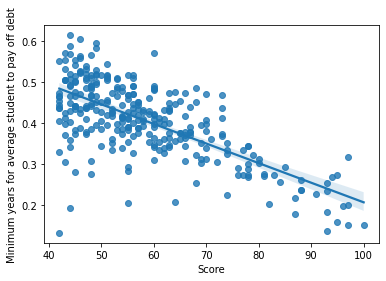

In [243]:
univ_df["avgMinYearsToPayDebt"] = univ_df["csTypicalDebt"]/univ_df["payscaleOverallStarting"]
ax = sns.regplot(x="vDisplayScoreInt", y="avgMinYearsToPayDebt", data=univ_df)
ax.set(xlabel="Score", ylabel="Minimum years for average student to pay off debt")

We can see a fairly clear trend; going to a higher-ranked university means, on average, you'll come out of school with a debt that's *easier* for you to pay. 

### Other Relevant Money Factords

In [ ]:
other_factors = ["csAvgCost", "csTypicalDebt", "avgGradDebt", "vPrivateTuition"] #"pctPell"]
plot_factors_against_score(other_factors, 2)

Interestingly, in this data, we can see there's a relationship between score and tuition/fees, but there's also a weak *inverse* linear correlations between loan indebtedness and school rank. In other words, people who go to more prestigious universities leave with *less* debt than their peers on average, despite the fact their schools have higher tuitions! 

There are multiple reasons this could be true -- it could be because they are more likely to get scholarships, either from the school or from external sources, or it could be that the students at higher-ranked universities are from families with more wealth than on average.  

## Final Predictive Model

#### Imputation
Since now we're looking at all of the numeric variables, we need to go back and consider how we will deal with the missing values. One solution would be to just drop it (like we did with the display scores), but that would mean losing out on a lot of valuable data and possibly bias the results. A more sophisticated solution is *multiple imputation*, where we create multiple data sets where the missing values have been substituted with guesses based on the distribution of the non-missing values, then calculate the regression on those data sets and combine them. 

However, the imputation method can only handle so much missing data before it errors. In addition, we need to remove the variables which only apply to a subset of the rows, because otherwise the algorithm will attempt to erroneously impute them (e.g. a public school should not have the value for "average private tuition" imputed). I manually went through the list above and (using domain knowledge) determined which ones to drop.

In [248]:
univ_df_num_drop = univ_df_num.drop(labels=["earlyDecAcceptRate", "vPrivateTuition", 
                                            "vOutStateTuition", "vInStateTuition"], axis=1)

C:\Users\ithin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\imputation\mice.py:967: RuntimeWarning: covariance is not positive-semidefinite.
  self.params[vname] = np.random.multivariate_normal(mean=mu, cov=cov)


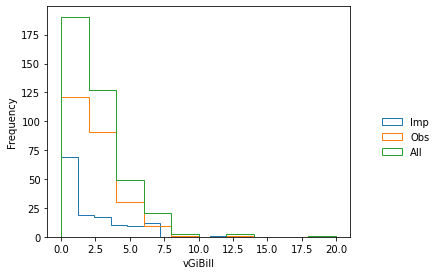

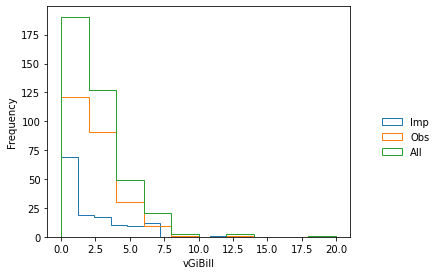

In [249]:
from statsmodels.imputation import mice

# Create the formula for regression (use all other columns to predict score)
x_vars = list(univ_df_num_drop.columns)
x_vars.remove("vDisplayScoreInt")
fml = f"vDisplayScoreInt ~ {' + '.join(x_vars)}"

imp = mice.MICEData(univ_df_num_drop)
imp.update_all(20)
imp.plot_imputed_hist("vGiBill")

The above graph shows an example of the imputation of a variable (`vGiBill`). The orange outlined histogram indicates the distribution of the original (observed) data, and the blut outlined represents the data generated by the imputation. 

In [250]:
result = mice.MICE(fml, sm.OLS, imp).fit(20,20)
result.summary()

C:\Users\ithin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\imputation\mice.py:967: RuntimeWarning: covariance is not positive-semidefinite.
  self.params[vname] = np.random.multivariate_normal(mean=mu, cov=cov)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                             Results: MICE
=======================================================================================================
Method:                            MICE                            Sample size:                    392 
Model:                             OLS                             Scale                           9.30
Dependent variable:                vDisplayScoreInt                Num. imputations                20  
-------------------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.    t    P>|t|    [0.025   0.975]   FMI  
-------------------------------------------------------------------------------------------------------
Intercept                                      0.0068   0.0257  0.2670 0.7895   -0.0434   0.0571 0.5016
latitude                                       0.0181   0.0464  0.3899 0.6966   -0.0729   0.1091 0.2521
longitude                                      0.0347   0.0142  2.4463 0.0144    0.0069   0.0626 0.1647
rCAcceptRate                                  -0.0438   0.0147 -2.9845 0.0028   -0.0725  -0.0150 0.1565
vStudentFacultyRatio                          -0.3617   0.0825 -4.3816 0.0000   -0.5235  -0.1999 0.2873
gradRate4Year                                  0.0745   0.0380  1.9581 0.0502   -0.0001   0.1491 0.3685
totalAllStudents                               0.0068   0.0061  1.1112 0.2665   -0.0052   0.0188 0.0770
wRoomBoard                                     0.0003   0.0001  2.8777 0.0040    0.0001   0.0005 0.1523
rCAvgPctGrad6Yr                                0.1027   3.6628  0.0280 0.9776   -7.0762   7.2816 0.4351
pellGradRate                                   0.0138   0.0580  0.2377 0.8121   -0.1000   0.1275 0.4049
nonPellGradrate                               -0.0302   0.0632 -0.4780 0.6326   -0.1541   0.0937 0.3634
rCPctClasses119                               -0.3805   1.0915 -0.3486 0.7274   -2.5198   1.7589 0.8430
rCPctClassesGt50                              -0.0392   0.2617 -0.1497 0.8810   -0.5522   0.4738 0.7058
applicationFee                                 0.0039   0.0192  0.2054 0.8372   -0.0336   0.0415 0.4058
totalUndergrads                               -0.0067   0.0061 -1.0941 0.2739   -0.0187   0.0053 0.0777
totalGradsAndPros                             -0.0067   0.0061 -1.0882 0.2765   -0.0187   0.0053 0.0763
pctPell                                        0.0978   0.0460  2.1252 0.0336    0.0076   0.1881 0.2499
enrollmentMilitaryTotalCyPct                  -0.0573   0.0979 -0.5857 0.5581   -0.2492   0.1345 0.4765
csAvgCost                                     -0.0002   0.0001 -1.3720 0.1701   -0.0005   0.0001 0.1670
csTypicalDebt                                 -0.0068   0.0069 -0.9840 0.3251   -0.0204   0.0068 0.3377
csTypicalDebtNograduate                       -0.0000   0.0001 -0.1853 0.8530   -0.0002   0.0002 0.0670
csTypicalLoanPayMonthly                        0.7301   0.7252  1.0067 0.3141   -0.6914   2.1515 0.3355
avgGradDebt                                   -0.0001   0.0000 -1.9021 0.0572   -0.0002   0.0000 0.2254
pctIncuredDebt                                -0.0009   0.0339 -0.0274 0.9781   -0.0674   0.0655 0.3298
vGiBill                                       -0.0519   0.1384 -0.3750 0.7076   -0.3233   0.2194 0.4539
csPctRcvFedLoan                               -0.0319   0.0312 -1.0224 0.3066   -0.0930   0.0292 0.2142
envCamSize                                     0.0002   0.0001  1.5352 0.1247   -0.0001   0.0005 0.1085
regPctAllCars                                 -0.0002   0.0121 -0.0133 0.9894   -0.0238   0.0235 0.5529
trfMinGpaCol                                   0.9414   0.7817  1.2042 0.2285   -0.5908   2.4735 0.2813
gClassSizes_vClasses1                          0.1293   0.9573  0.1351 0.8925   -1.7470   2.0057 0.8574
gClassSizes_vClasses2                       

We can see from this that a majority of the p-values here are relatively high (meaning the correlation isn't significant), and the coefficients are on average very similar to zero. However,  
- pctPell (coeff = 0.0978, p-value = 0.0336)
- gSat1600ScaleChart_satGridRng1600 (coeff = 0.0545, p-value = 0.0012)
- rCAvgPctGrad6YrPercentile (coeff = 0.2005, p-value = 0.0035)

However, these values are still low, indicating that a regression like this is certainly overfitting the data. To make a more regression that does not overfit, one should investigate using hold-out training data -- in other words, only training on a certain percentage of the data and validating against a different set. 

## Data Conclusions
- The rankings are more obtuse than expected, meaning that people should not trust US News's ranking to be as transparent as they expected (further analysis is needed to figure out the truth behind the ranking)
- Generally, higher-ranked colleges are, above all, more selective (i.e. ranking correlates inversely with acceptance rate), and a primary correlation in ranks is the SAT scores of the participating students. This leads us to question whether schools are highly rated because of the schools themselves, or because of the students that go there.
- Even if higher-ranked colleges are more expensive, it's stil worth it go to there because of the competing effects of lower debt rates and higher expected salaries. 

## Conclusion
In this project, I collected data from the US News website for college rankings, turned it into a form which can be coralled into a pandas DataFrame, then did various exploratory analysis and prediction to analyze how the ranking metric functions as well as find any other factors to which it relates. I found that there are interesting, nonlinear relationships between the data used for calculating the rankings and the rankings themselves, found other correlating variables which show a strong relationship with rankings, extended the analysis to consider factors like salary and major. There are many possible extensions to this project, including creating a regression that uses holdout sets to avoid overfitting and incorporating other data sets (such as expected salary per major). Either way, there is a wealth of data 